# Library

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception
# Others
import shutil
import random

# Load dataset

In [4]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Apple/train",
    label_mode="categorical",
    class_names=['Apple Black rot', 'Apple Scab Leaf', 'Apple leaf Healthy', 'Apple rust leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Apple/valid",
    label_mode="categorical",
    class_names=['Apple Black rot', 'Apple Scab Leaf', 'Apple leaf Healthy', 'Apple rust leaf'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 8014 files belonging to 4 classes.
==========================Validation Data====================
Found 1943 files belonging to 4 classes.


In [5]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1.0/256.)
test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/Apple/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/Apple/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 8014 images belonging to 4 classes.
Found 1943 images belonging to 4 classes.


# List Resource

In [6]:
# Check GPU
!nvidia-smi

Sat May 27 11:35:45 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 532.03                 Driver Version: 532.03       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   53C    P0               34W /  N/A|   4614MiB /  6144MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling Without Augmentation

## Xception Model

In [9]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Apple_Xception_model1_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [10]:
# Define Model
Xception1_model = tf.keras.models.Sequential([
    # Xception Layer
    Xception(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(4, activation='softmax') 
  ])


# Compile Model
Xception1_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
Xception1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 21,387,052
Trainable params: 21,332,524
Non-trainable params: 54,528
_______________________________________

In [11]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_Xception_model_1 = Xception1_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
401/401 [==============================] - ETA: 0s - loss: 0.2713 - accuracy: 0.9117
Epoch 1: val_accuracy improved from -inf to 0.81987, saving model to Apple_Xception_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_Xception_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_Xception_model1_Based_Non_Augmented\assets


401/401 [==============================] - 131s 307ms/step - loss: 0.2713 - accuracy: 0.9117 - val_loss: 2.4940 - val_accuracy: 0.8199 - lr: 0.0010
Epoch 2/100
401/401 [==============================] - ETA: 0s - loss: 0.1031 - accuracy: 0.9730
Epoch 2: val_accuracy improved from 0.81987 to 0.95368, saving model to Apple_Xception_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_Xception_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_Xception_model1_Based_Non_Augmented\assets


401/401 [==============================] - 120s 299ms/step - loss: 0.1031 - accuracy: 0.9730 - val_loss: 0.1832 - val_accuracy: 0.9537 - lr: 0.0010
Epoch 3/100
401/401 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 0.9768
Epoch 3: val_accuracy did not improve from 0.95368
401/401 [==============================] - 107s 266ms/step - loss: 0.0783 - accuracy: 0.9768 - val_loss: 0.1952 - val_accuracy: 0.9496 - lr: 0.0010
Epoch 4/100
401/401 [==============================] - ETA: 0s - loss: 0.0699 - accuracy: 0.9800
Epoch 4: val_accuracy did not improve from 0.95368
401/401 [==============================] - 107s 267ms/step - loss: 0.0699 - accuracy: 0.9800 - val_loss: 0.1946 - val_accuracy: 0.9424 - lr: 0.0010
Epoch 5/100
401/401 [==============================] - ETA: 0s - loss: 0.0361 - accuracy: 0.9891
Epoch 5: val_accuracy improved from 0.95368 to 0.98662, saving model to Apple_Xception_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_Xception_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_Xception_model1_Based_Non_Augmented\assets


401/401 [==============================] - 124s 308ms/step - loss: 0.0361 - accuracy: 0.9891 - val_loss: 0.0349 - val_accuracy: 0.9866 - lr: 0.0010
Epoch 6/100
401/401 [==============================] - ETA: 0s - loss: 0.0405 - accuracy: 0.9885
Epoch 6: val_accuracy did not improve from 0.98662
401/401 [==============================] - 110s 273ms/step - loss: 0.0405 - accuracy: 0.9885 - val_loss: 0.1051 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 7/100
401/401 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 0.9893
Epoch 7: val_accuracy did not improve from 0.98662
401/401 [==============================] - 112s 278ms/step - loss: 0.0367 - accuracy: 0.9893 - val_loss: 0.6951 - val_accuracy: 0.8893 - lr: 0.0010
Epoch 8/100
401/401 [==============================] - ETA: 0s - loss: 0.0864 - accuracy: 0.9775
Epoch 8: val_accuracy did not improve from 0.98662
401/401 [==============================] - 111s 276ms/step - loss: 0.0864 - accuracy: 0.9775 - val_loss: 0.3158 

INFO:tensorflow:Assets written to: Apple_Xception_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_Xception_model1_Based_Non_Augmented\assets


401/401 [==============================] - 124s 309ms/step - loss: 0.0537 - accuracy: 0.9847 - val_loss: 0.0232 - val_accuracy: 0.9943 - lr: 0.0010
Epoch 10/100
401/401 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.9898
Epoch 10: val_accuracy improved from 0.99434 to 0.99691, saving model to Apple_Xception_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_Xception_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_Xception_model1_Based_Non_Augmented\assets


401/401 [==============================] - 124s 309ms/step - loss: 0.0333 - accuracy: 0.9898 - val_loss: 0.0141 - val_accuracy: 0.9969 - lr: 0.0010
Epoch 11/100
401/401 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9953
Epoch 11: val_accuracy did not improve from 0.99691
401/401 [==============================] - 111s 275ms/step - loss: 0.0137 - accuracy: 0.9953 - val_loss: 0.1815 - val_accuracy: 0.9429 - lr: 0.0010
Epoch 12/100
401/401 [==============================] - ETA: 0s - loss: 0.0382 - accuracy: 0.9909
Epoch 12: val_accuracy did not improve from 0.99691
401/401 [==============================] - 112s 280ms/step - loss: 0.0382 - accuracy: 0.9909 - val_loss: 0.1186 - val_accuracy: 0.9696 - lr: 0.0010
Epoch 13/100
401/401 [==============================] - ETA: 0s - loss: 0.0319 - accuracy: 0.9908
Epoch 13: val_accuracy improved from 0.99691 to 0.99949, saving model to Apple_Xception_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: Apple_Xception_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_Xception_model1_Based_Non_Augmented\assets


401/401 [==============================] - 124s 309ms/step - loss: 0.0319 - accuracy: 0.9908 - val_loss: 0.0045 - val_accuracy: 0.9995 - lr: 0.0010
Epoch 14/100
401/401 [==============================] - ETA: 0s - loss: 0.0281 - accuracy: 0.9921
Epoch 14: val_accuracy did not improve from 0.99949
401/401 [==============================] - 109s 271ms/step - loss: 0.0281 - accuracy: 0.9921 - val_loss: 0.0488 - val_accuracy: 0.9830 - lr: 0.0010
Epoch 15/100
401/401 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.9946
Epoch 15: val_accuracy did not improve from 0.99949
401/401 [==============================] - 110s 274ms/step - loss: 0.0200 - accuracy: 0.9946 - val_loss: 0.1337 - val_accuracy: 0.9774 - lr: 0.0010
Epoch 16/100
401/401 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 0.9878
Epoch 16: val_accuracy did not improve from 0.99949
401/401 [==============================] - 110s 275ms/step - loss: 0.0424 - accuracy: 0.9878 - val_loss: 0

INFO:tensorflow:Assets written to: Apple_Xception_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: Apple_Xception_model1_Based_Non_Augmented\assets


401/401 [==============================] - 123s 307ms/step - loss: 0.0072 - accuracy: 0.9980 - val_loss: 6.3718e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 24/100
401/401 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9988
Epoch 24: val_accuracy did not improve from 1.00000
401/401 [==============================] - 108s 268ms/step - loss: 0.0044 - accuracy: 0.9988 - val_loss: 5.2990e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 25/100
401/401 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000
Epoch 25: val_accuracy did not improve from 1.00000
401/401 [==============================] - 110s 273ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 2.3748e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 26/100
401/401 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9994
Epoch 26: val_accuracy did not improve from 1.00000
401/401 [==============================] - 110s 274ms/step - loss: 0.0025 - accura

Text(0.5, 1.0, 'Training and validation loss DIY Model')

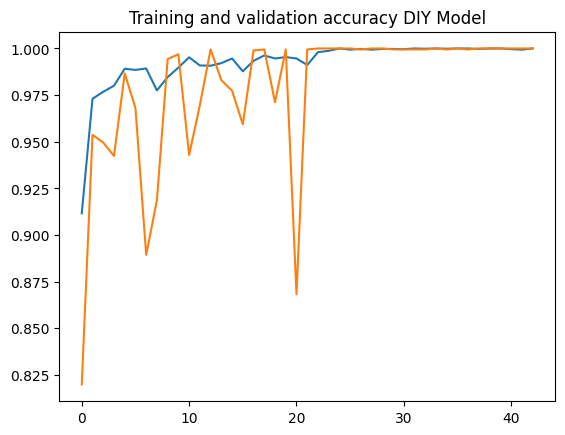

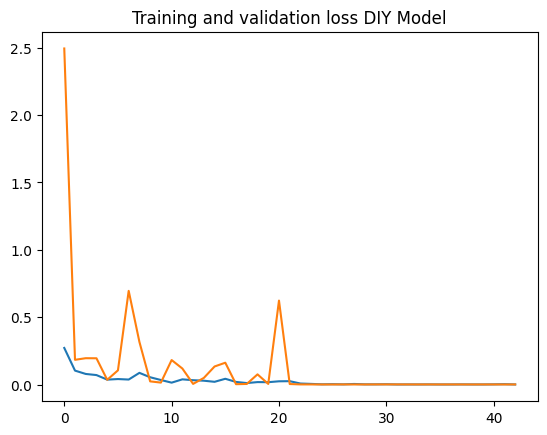

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_Xception_model_1.history['accuracy' ]
val_acc  = history_Xception_model_1.history['val_accuracy' ]
loss     = history_Xception_model_1.history['loss' ]
val_loss = history_Xception_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model')